In [2]:
# Data loading libraries 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Model set up libraries 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import backend

from tensorflow.keras.applications import VGG16

from sklearn.model_selection import train_test_split

In [4]:
import glob
from PIL import Image
from tensorflow.keras.preprocessing import image
import numpy as np

# Loading Images

## Path to .jpeg from zip

In [5]:
!unzip drive/MyDrive/SOLAR_ROOF/solar_jpegs.zip > /dev/null

In [6]:

folders_jpeg = ['train_RGB_tiles_jpeg', 'train_mask_tiles_jpeg']
folder_path_jpeg = [f'{folder}/*.jpeg' for folder in folders_jpeg]
folder_path_jpeg

['train_RGB_tiles_jpeg/*.jpeg', 'train_mask_tiles_jpeg/*.jpeg']

In [7]:
test_path, train_path = [], []
test_path =[filename for filename in glob.glob(folder_path_jpeg[1])] # masks
train_path = [filename for filename in glob.glob(folder_path_jpeg[0])] # rgb


## Path to Images.tif

In [14]:
root_path = 'drive/MyDrive/SOLAR_ROOF/'
folders = ['tiled_test_images', 'tiled_train_images']
folder_path = [f'{root_path}{folder}/*.tif' for folder in folders]
folder_path

['drive/MyDrive/SOLAR_ROOF/tiled_test_images/*.tif',
 'drive/MyDrive/SOLAR_ROOF/tiled_train_images/*.tif']

In [ ]:
test_path, train_path = [], []
test_path =[filename for filename in glob.glob(folder_path[0])]
train_path = [filename for filename in glob.glob(folder_path[1])]


# Creating X and y

In [8]:
test_path.sort()
train_path.sort()


In [9]:
# test_path = test_path[:10]
# train_path = train_path[:10]

In [10]:
%%time
X = [] # Image
y = [] # Mask
images_X = []
images_y = []
count_1 = 0
count_2 = 0
for filename in train_path:
  im = Image.open(filename)
  # print(filename)
  images_X.append(im)
  im_resized = im.resize((224,224))
  X.append(image.img_to_array(im_resized))

for filename in test_path:
  im = Image.open(filename)
  # print(filename)
  images_y.append(im)
  im_resized = im.resize((224,224))
  y.append(image.img_to_array(im_resized))
  
X = np.array(X) / 255.
y = np.array(y) / 255.

CPU times: user 3.58 s, sys: 640 ms, total: 4.22 s
Wall time: 4.22 s


### Optional Inspection

In [11]:
y[0].max()

1.0

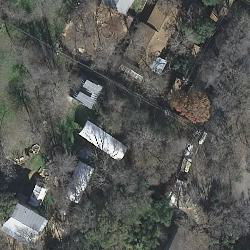

In [12]:
images_X[10]

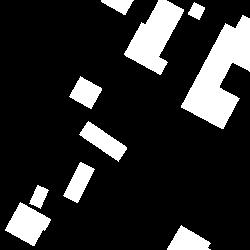

In [13]:
images_y[10]

In [14]:
X.shape

(1001, 224, 224, 3)

In [15]:
y.shape

(1001, 224, 224, 1)

# Model Set Up

## Standard U-Net

Convolution block - used to perform the primary operation of taking the entered input parameters and processing a double layer of convolution operations. 

In [ ]:
def convolution_operation(entered_input, filters=64):
  # Taking first input and implementing the first conv block
  conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
  batch_norm1 = BatchNormalization()(conv1)
  act1 = ReLU()(batch_norm1)
  
  # Taking first input and implementing the second conv block
  conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
  batch_norm2 = BatchNormalization()(conv2)
  act2 = ReLU()(batch_norm2)

### 
# padding = 'same' to maintain the same shapes
  
  return act2


**Constructing the encoder**
- use consecutive inputs starting from the first layer all the way to the bottom
- will use the convolution_operation (two conv2d layers, 2 batch norms and 2 ReLU activations)
- downsample the response of convolution_operation
- use max pooling 
- return initial output and the max-pooled output (used for performing skip connections)

In [ ]:
def encoder(entered_input, filters=64):
  # Collect the start and end of each sub-block for normal pass and skip connections
  enc1 = convolution_operation(entered_input, filters)
  MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
  return enc1, MaxPool1

**Constructing the decoder**
- include three arguments (recieving inputs, input of skip connection, number of filters)
- upsamples the entered input with help of Conv2DTranspose layers 
- concatenate both receiving input and newly upsampled layers and receive value of skip connections
- use combined function and perform convolutional block operation to proceed to next layer and return output value

In [ ]:
def decoder(entered_input, skip, filters=64):
  # Upsampling and concatenating the essential features
  Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
  Connect_Skip = Concatenate()([Upsample, skip])
  out = convolution_operation(Connect_Skip, filters)
  return out

**Constructing the U-Net architecture**
- use the input layer which will contain the respective shapes of our input image
- collect primary outputs and the skip outputs to pass them onto further blocks 
- create the next block and construct the entire decoder architecture until we reach output 
- output will have required dimensions according to our desired output
- call functional API modelling system to create final model and return this model to the user for performing tasks

In [ ]:
def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

### Finalizing the Model:



- ensure the image shapes are divisilbe by at least 16 or multiples of 16
  - since we are using four max-pooling laters during the down-sampling procedure we dont want to encounter the divisibility of any odd number shapes

In [ ]:
X.shape[1:]

(160, 160, 3)

In [ ]:
keras.backend.clear_session()

input_shape = X.shape[1:] # (160, 160, 3)
model = U_Net(input_shape)
model_iou = U_Net(input_shape)


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 160, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

**Binary CrossEntropy Loss**

In [ ]:
# opt = Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy',
                optimizer='adam')

In [ ]:
# plot_model(model, 'model.png', show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

**IoU Loss**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras import backend

In [ ]:
def jacard_coef(y_true, y_pred):
  y_true_f = backend.flatten(y_true)
  y_pred_f = backend.flatten(y_pred)
  intersection = backend.sum(y_true_f * y_pred_f)
  return (intersection + 1.0) / (backend.sum(y_true_f) + backend.sum(y_pred_f) - intersection + 1.0)

In [ ]:
def jacard_coef_loss(y_true, y_pred):
  return -jacard_coef(y_true, y_pred) # - to minimise the loss

In [ ]:
model_iou.compile(loss=[jacard_coef_loss], metrics=[jacard_coef], optimizer='adam')

## Transfer Learning Model VGG16

In [26]:
class SMR_Model():
    ''' creating our first lwb_smr models '''

    def __init__(self, input_shape):
        self.input_shape = input_shape

    def get_latest_model(self):
        model = self.build_vgg16_unet(self.input_shape)
        model = self.compile_model(model)

        return model

    def convolution_block(self, inputs, num_filters):
        ''' simple UNET convolution block with BatchNormalisation '''

        # convolution layer 1 of the block
        x = Conv2D(num_filters, (3,3), padding='same')(inputs)  # padding='same' to avoid cut-down with conv
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # convolution layer 2 of the block
        x = Conv2D(num_filters, (3,3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # max pooling not used here as just the bridge

        return x

    def decoder_block(self, inputs, skip_tensor, num_filters):
        ''' decoder block for UNET '''
        # adds in the skips with concatenate
        x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(inputs) # stride important here to up-sample
        x = Concatenate()([x, skip_tensor])     # bringing in skip layer
        x = self.convolution_block(x, num_filters)

        return x

    def build_vgg16_unet(self):
        ''' build vgg-16 '''

        inputs = Input(self.input_shape)

        # see actual VGG-16 here: https://github.com/keras-team/keras/blob/v2.9.0/keras/applications/vgg16.py#L43-L227
        vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
        # vgg16.summary()
        vgg16.trainable = False

        ''' Encoder - skip layers '''
        skip1 = vgg16.get_layer('block1_conv2').output #  256 x 256, 64 filters in vgg16
        skip2 = vgg16.get_layer('block2_conv2').output #  128 x 128, 128 filters in vgg16
        skip3 = vgg16.get_layer('block3_conv3').output #   64 x 64, 256 filters in vgg16
        skip4 = vgg16.get_layer('block4_conv3').output #   32 x 32, 512 filters in vgg16
        # display('skip4: ' + str(skip4.shape))

        # only need to specify the skip layers, as VGG16 is an Encoder
        # Therefore, VGG16 comes built with MaxPool2d, so we don't specify

        ''' Bridge '''
        bridge = vgg16.get_layer('block5_conv3').output # 16 x 16, with 512 filters in vgg16
        # display('bridge: ' + str(bridge.shape))


        ''' Decoder '''
        d1 = self.decoder_block(bridge, skip4, 512) #  512 filters, as per the bridge
        d2 = self.decoder_block(d1, skip3, 256) #  256 filters
        d3 = self.decoder_block(d2, skip2, 128) #  128 filters
        d4 = self.decoder_block(d3, skip1, 64)  #   64 filters

        ''' Output '''
        outputs = Conv2D(1, (1,1), padding='same', activation='sigmoid')(d4)

        model = Model(inputs, outputs, name='first_VGG16_UNET')

        return model

    def compile_model(self, m):
        ''' compile as a basic unet for now... first actual run '''
        m.compile(
            loss='binary_crossentropy',
            optimizer='adam'
        )
        return m


In [27]:
X.shape

(1001, 160, 160, 3)

In [28]:
get_vgg = SMR_Model((224,224,3))
tl_model = get_vgg.build_vgg16_unet()
tl_model_compiled = get_vgg.compile_model(tl_model)

58900480/58889256 [==============================] - 0s 0us/step


### Transfer Learning Model Summary

In [26]:
tl_model_compiled.summary()

Model: "first_VGG16_UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 160, 160, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 160, 160, 64  36928       ['block1_conv1[0][0]']           
                                )                                                  

## Transfer Learning Model RESNET50

In [20]:
class BuildResNet50():

  def __init__(self, input_shape):
    self.input_shape = input_shape

  def convolution_block(self, inputs, num_filters):
    """Simple UNET Convolution block with BatchNormalisation"""

    # Conv layer 1 of block 
    x = Conv2D(num_filters, (3,3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Conv layer 2 of block
    x = Conv2D(num_filters, (3,3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

  def decoder_block(self, inputs, skip_tensor, num_filters):
    """ Decoder block from U-Net"""

    # Add in skips with concatenate
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(inputs)
    x = Concatenate()([x, skip_tensor])
    x = self.convolution_block(x, num_filters)

    return x


  def build_resnet50(self):

    inputs = Input(self.input_shape)

    resnet = ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs 
    )
    resnet.trainable = False
    
    ### Get skip layers
    skip1 = resnet.get_layer('input_1').output #  512 x 512, 3 filters in resnet50
    skip2 = resnet.get_layer('conv1_relu').output #  256 x 256, 64 filters in resnet50
    skip3 = resnet.get_layer('conv2_block3_out').output #   128 x 128, 256 filters in resnet50
    skip4 = resnet.get_layer('conv3_block4_out').output #   64 x 64, 512 filters in resnet50

    print(skip1.shape, skip2.shape, skip3.shape, skip4.shape)
    
    ## Bridge 
    bridge = resnet.get_layer('conv4_block6_out').output # 16 x 16, with 512 filters in vgg16
    print(bridge.shape)

    
    ### Decoder
    d1 = self.decoder_block(bridge, skip4, 512) #  512 filters, as per the bridge
    d2 = self.decoder_block(d1, skip3, 256) #  256 filters
    d3 = self.decoder_block(d2, skip2, 128) #  128 filters
    d4 = self.decoder_block(d3, skip1, 64)  #   64 filters

    ### Output
    outputs = Conv2D(1, (1,1), padding='same', activation='sigmoid')(d4)

    model = Model(inputs, outputs, name='first_RESNET50_UNET')

    return model

  def compile_model(self, m):
        ''' compile as a basic unet for now... first actual run '''
        m.compile(
            loss='binary_crossentropy',
            optimizer='adam'
        )
        return m
  

In [26]:
backend.clear_session()
get_resnet = BuildResNet50((224,224,3))
model_resnet = get_resnet.build_resnet50()
model_resnet_compiled = get_resnet.compile_model(model_resnet)


(None, 224, 224, 3) (None, 112, 112, 64) (None, 56, 56, 256) (None, 28, 28, 512)
(None, 14, 14, 1024)


## Loading Model

In [16]:
loaded_model = keras.models.load_model('drive/MyDrive/models_checkpointed_day5_am.h5')

# Model Training 


In [27]:
X[:].shape

(1200, 160, 160, 3)

In [28]:
np.max(X[:,:,:,:])

1.0

## Spliting into test and train:

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=5)

In [24]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

X_train:  (900, 224, 224, 3)
X_test:  (101, 224, 224, 3)


## Trainning model

In [25]:
es = EarlyStopping(patience=5, restore_best_weights=True)
mc = ModelCheckpoint('resnet50_unet.h5', save_best_only=True)

### Standard U-Net Model

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.3,
                    batch_size=8, epochs=15,
                    callbacks=[mc])

**Using IoU Loss Metrics**

In [ ]:
history_iou = model_iou.fit(X_train, y_train, validation_split=0.3,
                    batch_size=8, epochs=15,
                    callbacks=[mc])

Epoch 1/15
95/95 [==============================] - 39s 319ms/step - loss: -0.4158 - jacard_coef: 0.4157 - val_loss: -2.4166e-04 - val_jacard_coef: 2.4190e-04
Epoch 2/15
95/95 [==============================] - 27s 281ms/step - loss: -0.5337 - jacard_coef: 0.5349 - val_loss: -2.6443e-04 - val_jacard_coef: 2.6467e-04
Epoch 3/15
95/95 [==============================] - 28s 293ms/step - loss: -0.5700 - jacard_coef: 0.5698 - val_loss: -0.2379 - val_jacard_coef: 0.2372
Epoch 4/15
95/95 [==============================] - 26s 272ms/step - loss: -0.5947 - jacard_coef: 0.5937 - val_loss: -0.3208 - val_jacard_coef: 0.3194
Epoch 5/15
95/95 [==============================] - 27s 286ms/step - loss: -0.5942 - jacard_coef: 0.5947 - val_loss: -0.0379 - val_jacard_coef: 0.0386
Epoch 6/15
95/95 [==============================] - 28s 291ms/step - loss: -0.6159 - jacard_coef: 0.6161 - val_loss: -0.6125 - val_jacard_coef: 0.6118
Epoch 7/15
95/95 [==============================] - 27s 282ms/step - loss: -0.

### Transfer Learning U-Net VGG16

In [32]:
history_tl = tl_model.fit(X_train, y_train, validation_split=0.3,
                    batch_size=8, epochs=15,
                    callbacks=[mc])

Epoch 1/15
79/79 [==============================] - 35s 232ms/step - loss: 0.2643 - val_loss: 0.2925
Epoch 2/15
79/79 [==============================] - 14s 183ms/step - loss: 0.1843 - val_loss: 0.2425
Epoch 3/15
79/79 [==============================] - 15s 185ms/step - loss: 0.1639 - val_loss: 0.1907
Epoch 4/15
79/79 [==============================] - 15s 187ms/step - loss: 0.1505 - val_loss: 0.1694
Epoch 5/15
79/79 [==============================] - 14s 183ms/step - loss: 0.1316 - val_loss: 0.2280
Epoch 6/15
79/79 [==============================] - 15s 191ms/step - loss: 0.1220 - val_loss: 0.1494
Epoch 7/15
79/79 [==============================] - 15s 187ms/step - loss: 0.1124 - val_loss: 0.1817
Epoch 8/15
79/79 [==============================] - 15s 189ms/step - loss: 0.1064 - val_loss: 0.1869
Epoch 9/15
79/79 [==============================] - 15s 191ms/step - loss: 0.0995 - val_loss: 0.2022
Epoch 10/15
79/79 [==============================] - 15s 193ms/step - loss: 0.0989 - val_lo

### RESNET50 Model

In [27]:
history_resnet = model_resnet_compiled.fit(X_train, y_train, validation_split=0.3,
                    batch_size=8, epochs=15,
                    callbacks=[mc])

Epoch 1/15
79/79 [==============================] - 36s 248ms/step - loss: 0.3898 - val_loss: 1.7517
Epoch 2/15
79/79 [==============================] - 16s 202ms/step - loss: 0.3613 - val_loss: 1.0434
Epoch 3/15
79/79 [==============================] - 16s 201ms/step - loss: 0.3479 - val_loss: 0.5518
Epoch 4/15
79/79 [==============================] - 16s 199ms/step - loss: 0.3379 - val_loss: 0.6602
Epoch 5/15
79/79 [==============================] - 16s 207ms/step - loss: 0.3302 - val_loss: 0.4688
Epoch 6/15
79/79 [==============================] - 16s 201ms/step - loss: 0.3173 - val_loss: 0.5181
Epoch 7/15
79/79 [==============================] - 16s 208ms/step - loss: 0.3059 - val_loss: 0.8877
Epoch 8/15
79/79 [==============================] - 16s 205ms/step - loss: 0.2972 - val_loss: 0.6888
Epoch 9/15
79/79 [==============================] - 16s 205ms/step - loss: 0.2853 - val_loss: 0.4800
Epoch 10/15
79/79 [==============================] - 17s 220ms/step - loss: 0.2797 - val_lo

# Plotting functions

In [32]:
import matplotlib.pyplot as plt
import random

In [33]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    # ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['jacard_coef'], label='train jacard_coef'  + exp_name)
    ax2.plot(history.history['val_jacard_coef'], label='val val_jacard_coef'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('IoU')
    ax2.legend()
    return (ax1, ax2)

In [34]:
def plot_comparison(X_true, y_true, y_pred, a=0, b=1, c=2, title=''):
  f, axs = plt.subplots(3, 3, figsize=(12, 12))
  f.suptitle(title)
  ax1, ax2, ax3 = axs[0,0], axs[0,1], axs[0,2]
  ax4, ax5, ax6 = axs[1,0], axs[1,1], axs[1,2]
  ax7, ax8, ax9 = axs[2,0], axs[2,1], axs[2,2]

  ax1.imshow(X_true[a,:,:,:])
  ax1.set_title('Test Image')
  ax2.imshow(y_true[a,:,:,0], cmap='gray')
  ax2.set_title('Test Label')
  ax3.imshow(y_pred[a,:,:,0],cmap='gray')
  ax3.set_title('Prediction Label')

  ax4.imshow(X_true[b,:,:,:])
  ax5.imshow(y_true[b,:,:,0],cmap='gray')
  ax6.imshow(y_pred[b,:,:,0], cmap='gray')

  ax7.imshow(X_true[c,:,:,:])
  ax8.imshow(y_true[c,:,:,0], cmap='gray')
  ax9.imshow(y_pred[c,:,:,0], cmap='gray')

  # return axs

In [35]:
# plot_history(history, title='Trained U-Net')

# Predicting using model

Creating three random indexes to display images for both loss metrics.

In [39]:
idx = random.sample(range(0, X_test[:,:,:,:].shape[0]), 3)
a, b, c = idx[0], idx[1], idx[2]

##Binary cross entropy

In [ ]:
y_pred = model.predict(X_test) # y_true = y_test[1:]

In [ ]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 215ms/step - loss: 0.3405


0.34048816561698914

In [ ]:
# plot_history(history)

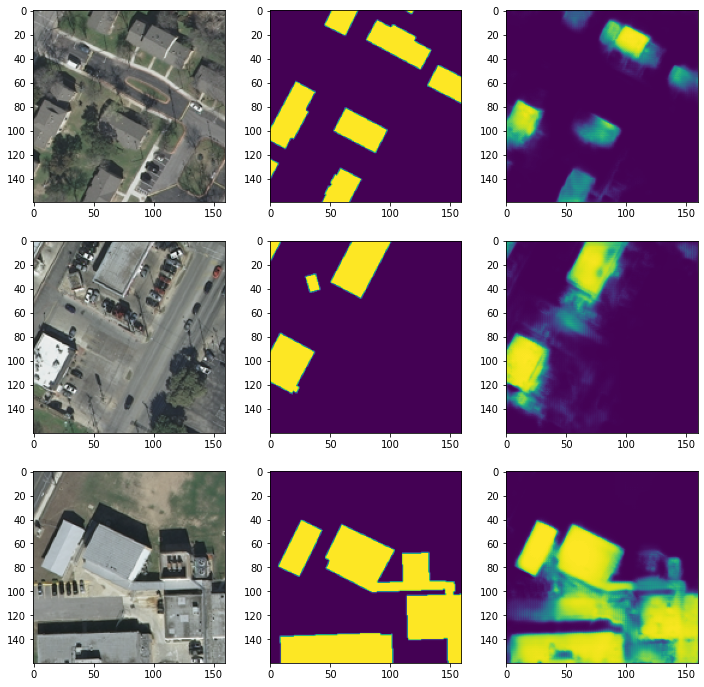

In [ ]:
plot_comparison(X_test, y_test, y_pred, a, b, c, title='Binary cross_entropy Loss Basic U_net')

##IoU Prediction

In [ ]:
y_pred_iou = model_iou.predict(X_test) # y_true = y_test[1:]

In [ ]:
model_iou.evaluate(X_test, y_test)

4/4 [==============================] - 1s 220ms/step - loss: -0.6795 - jacard_coef: 0.6759


[-0.6794849634170532, 0.6759035587310791]

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc946056250>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc9460bca10>)

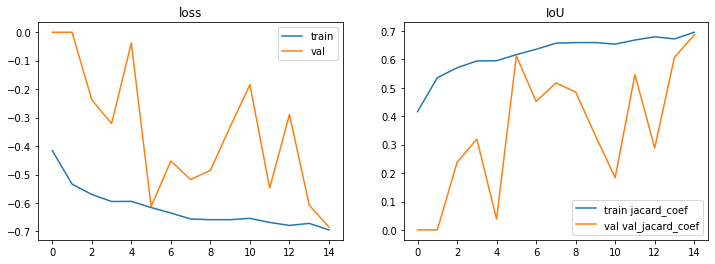

In [ ]:
plot_history(history_iou, a, b, c)

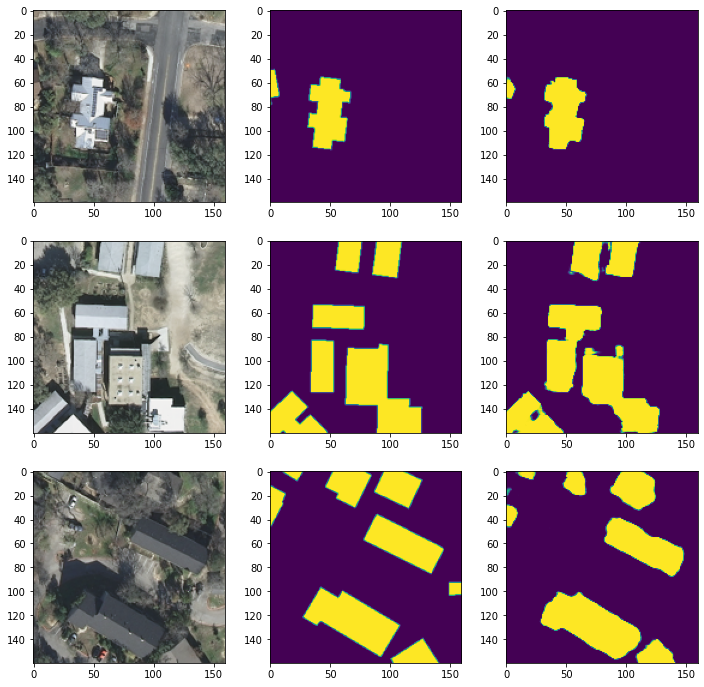

In [ ]:
plot_comparison(X_test, y_test, y_pred_iou, a, b, c, title='IoU Loss, basic U_Net')

In [ ]:
X_test[:,:,:,:].shape[0]

120

In [ ]:
random.sample(range(0, X_test[:,:,:,:].shape[0]), 3)

[60, 40, 63]

## Transfer Learning

In [37]:
y_pred_tl = tl_model.predict(X_test)

In [38]:
tl_model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 158ms/step - loss: 0.1782


0.17818960547447205

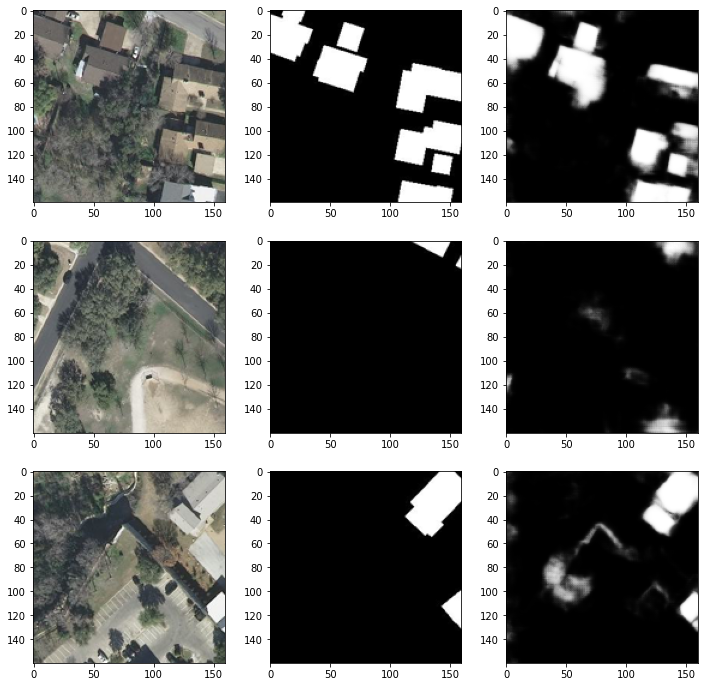

In [41]:
plot_comparison(X_test, y_test, y_pred_tl, a, b, c, title='Transfer Learning - VGG16-U_Net')

## ResNet50 model

In [36]:
y_pred_resnet = model_resnet_compiled.predict(X_test)

In [37]:
model_resnet_compiled.evaluate(X_test, y_test)

4/4 [==============================] - 1s 194ms/step - loss: 0.3432


0.34318047761917114

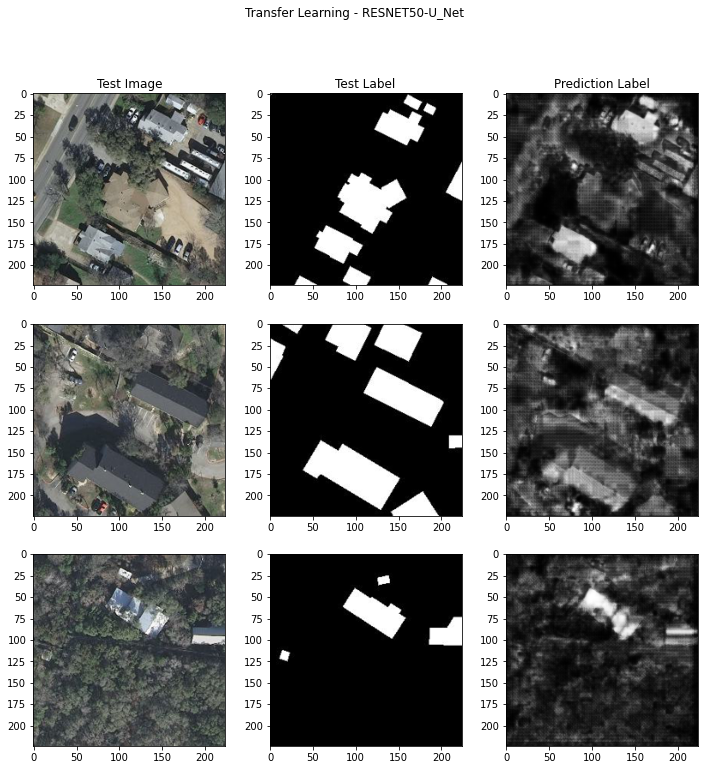

In [40]:
plot_comparison(X_test, y_test, y_pred_resnet, a, b, c, title='Transfer Learning - RESNET50-U_Net')

## Loading Model

In [33]:
test_loaded_model = keras.models.load_model('drive/MyDrive/models_checkpointed_day5_am.h5')
y_loaded_model_pred_check = test_loaded_model.predict(X_test)



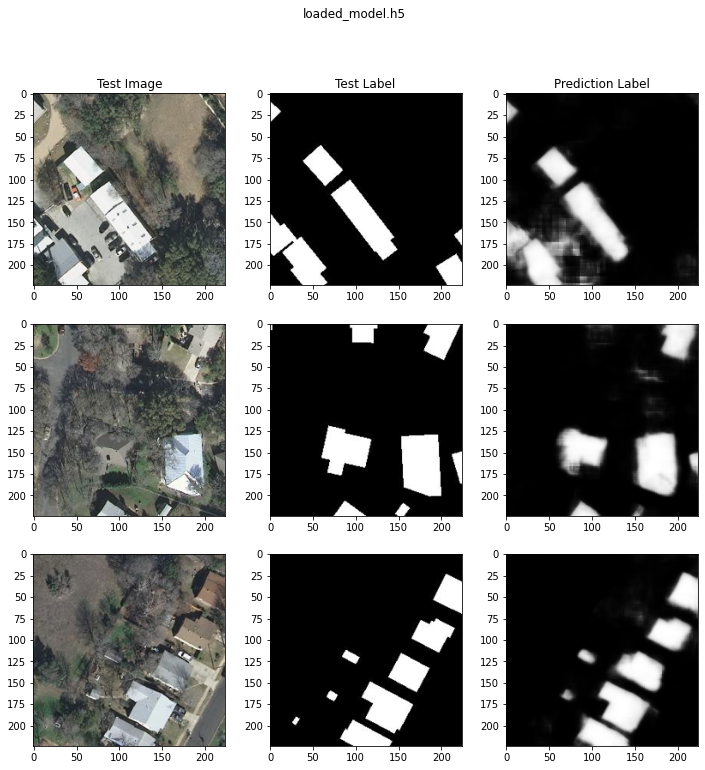

In [37]:
plot_comparison(X_test, y_test, y_loaded_model_pred_check, a=a, b=b, c=c, title='loaded_model.h5')